# Reinforcement Learning for Navigation Behavior Cloning Study

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from torchsummary import summary

import numpy as np

import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics
from pathlib import Path

import random

import networkx as nx

import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader

Using backend: pytorch


In [3]:
from rlnav.wrappers import AbsPosOnlyWrapper

from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToMultiGymWrapper 
from mlagents_envs.side_channel.environment_parameters_channel import EnvironmentParametersChannel
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

In [4]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [5]:
observation_config = {
  "use_occupancy": False,
  "use_whiskers": False,
  "use_depthmap": False,
  "curriculum_length":-1
}
environment_channel = EnvironmentParametersChannel()
for key, value in observation_config.items():
    environment_channel.set_float_parameter(key, value)

env_path = Path(fr"C:\Users\batua\Desktop\RLNav\NavigationEnvironments\Debug\Baseline")
unity_env = UnityEnvironment(str(env_path), base_port=5000 + random.randint(0,5000), side_channels=[environment_channel])
env = UnityToMultiGymWrapper(unity_env, env_channel=environment_channel)
ENV = AbsPosOnlyWrapper(env)

[INFO] Connected to Unity environment with package version 1.8.1-preview and communication version 1.4.0
[INFO] Connected new brain: Basic?team=0
[WARNING] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.


C:\Users\batua\anaconda3\envs\rlnav2\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [6]:
def test_model(model, test_count=500, random=False, pos_only=True):
  done_testing = False
  results = []
  obs = ENV.reset()

  while not done_testing:
    if pos_only:
      obs = np.array(obs).squeeze()
    actions = model(th.tensor(obs)).detach().numpy() if not random else np.random.uniform(low=-1, high=1, size=(32,3))
    obs, rews, dones, infos = ENV.step(actions)
    for (done, reward) in zip(dones, rews):
      if done:
        if reward == 1.0:
            results.append(1.0)
        elif reward == -1.0 or reward == 0.0:
            results.append(0.0)
      if test_count == len(results):
        done_testing = True
        break
  return sum(results) / len(results)

# random_success_rate = test_model(None, test_count=100, random=True)
# random_success_rate

## The Incoming Data

In [7]:
dataset_observations = np.load('Data/DebugRandom_obs.npy')
dataset_observations = dataset_observations.squeeze()

dataset_actions = np.load('Data/DebugRandom_actions.npy')
dataset_actions = dataset_actions.squeeze()

print("Loaded shape:", dataset_observations.shape, dataset_actions.shape)

Loaded shape: (25000, 19) (25000, 3)


In [8]:
agent_pos = dataset_observations[:, 13:16]
goal_pos  = dataset_observations[:, 16:19]

ACTIONS = dataset_actions
GRAPH_FEATURE_SET = np.stack([agent_pos, goal_pos], axis=1)
print(GRAPH_FEATURE_SET.shape)

(25000, 2, 3)


# Behavior Cloning Baseline

In [19]:
class BaselineNoGraph(pl.LightningModule): 
  def __init__(self, in_dim, h_feats=16):
    super(BaselineNoGraph, self).__init__()
    self.linear_1 = nn.Linear(in_dim, h_feats)
    self.linear_2 = nn.Linear(h_feats, h_feats)
    self.linear_3 = nn.Linear(h_feats, 3)
  
  def forward(self, x):
    x = F.relu(self.linear_1(x))
    x = F.dropout(F.relu(self.linear_2(x)), p=0.1) # To Introduce slight bit of randomess which helps
    x = self.linear_3(x)
    return x

In [20]:
baseline_dropout_results = []

baseline_observations_t = th.tensor(GRAPH_FEATURE_SET.reshape(-1,6)) 
baseline_actions_t = th.tensor(dataset_actions)

dataset = TensorDataset(baseline_observations_t, baseline_actions_t) # create your datset
dataloader = DataLoader(dataset, batch_size=8) # create your dataloader

for _ in range(5):
  model = BaselineNoGraph(6, 32)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  count_parameters(model)
  for epoch in range(5):
    for i, (x,y) in enumerate(dataloader):
      pred = model(x)
      loss = F.mse_loss(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i % 1000 == 0:
        print(f"Loss is {loss.item():.1e} at step {epoch * 3000 + i}")
  result = test_model(model)
  baseline_dropout_results.append(result)
baseline_dropout_results

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| linear_1.weight |    192     |
|  linear_1.bias  |     32     |
| linear_2.weight |    1024    |
|  linear_2.bias  |     32     |
| linear_3.weight |     96     |
|  linear_3.bias  |     3      |
+-----------------+------------+
Total Trainable Params: 1379
Loss is 4.2e-01 at step 0
Loss is 4.2e-02 at step 1000
Loss is 6.0e-02 at step 2000
Loss is 5.8e-02 at step 3000
Loss is 1.4e-01 at step 3000
Loss is 1.7e-02 at step 4000
Loss is 3.3e-02 at step 5000
Loss is 5.3e-02 at step 6000
Loss is 1.1e-01 at step 6000
Loss is 1.3e-02 at step 7000
Loss is 9.4e-03 at step 8000
Loss is 2.4e-02 at step 9000
Loss is 8.8e-02 at step 9000
Loss is 6.1e-03 at step 10000
Loss is 9.9e-03 at step 11000
Loss is 1.9e-02 at step 12000
Loss is 1.1e-01 at step 12000
Loss is 6.6e-03 at step 13000
Loss is 2.7e-02 at step 14000
Loss is 1.9e-02 at step 15000
+-----------------+------------+
|     Modules     | Para

[0.9, 1.0, 1.0, 1.0, 1.0]

In [18]:
baseline_results = np.array(baseline_results)
baseline_results.mean(), baseline_results.std() 

(0.8352, 0.1562183087861343)

In [21]:
baseline_dropout_results = np.array(baseline_dropout_results)
baseline_dropout_results.mean(), baseline_dropout_results.std() 

(0.9800000000000001, 0.03999999999999999)

In [11]:
agent_pos = dataset_observations[:, 13:16]
goal_pos  = dataset_observations[:, 16:19]

GRAPH_FEATURE_SET = np.stack([agent_pos, goal_pos], axis=1)
print(GRAPH_FEATURE_SET.shape)

(25000, 2, 3)


Node 0: Agent
Node 1: Goal


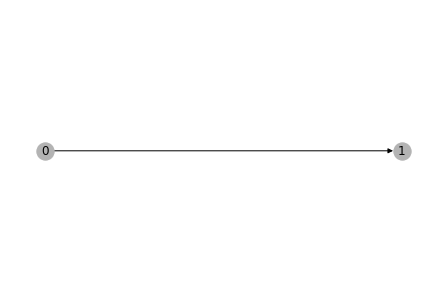

In [12]:
import json
jsonstr = """{"SourceNodes":[0],"DestinationNodes":[1],"NumNodes":2,"Features":[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]]}"""
jsonGraph = json.loads(jsonstr)

source_nodes = jsonGraph["SourceNodes"]
destination_nodes = jsonGraph["DestinationNodes"]
num_nodes = jsonGraph["NumNodes"]

GRAPH_SPECIFICATION = (source_nodes, destination_nodes)
def visualize_graph(g):
  nx_G = g.to_networkx()
  pos = nx.kamada_kawai_layout(nx_G)
  pos = nx.planar_layout(nx_G)
  nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

g = dgl.graph(GRAPH_SPECIFICATION, num_nodes=num_nodes)
visualize_graph(g)

print("Node 0: Agent")
print("Node 1: Goal")

In [13]:
from dgl.data import DGLDataset

class DebugAgentGoalPosDataset(DGLDataset):
  def __init__(self, specification, node_features_array, labels, edge_type="goal_to_agent", add_self_loops=True, add_node_id=True, gpu=True):
      self.device = "cuda:0" if gpu else "cpu"
      
      self.specification = specification
      self.node_features_array = node_features_array
      self.labels = th.tensor(labels, device=self.device)
      
      self.add_self_loops = add_self_loops
      self.edge_type = edge_type
      self.add_node_id = add_node_id
      
      super().__init__(name='DebugAgentGoalPosDataset')
        
  def process(self):
    self.graphs = []
    
    for graph_features in self.node_features_array:
      g = dgl.graph(self.specification)
      
      if self.add_self_loops:
        g = dgl.add_self_loop(g)
      
      if self.edge_type == "bi_directional":
        g = dgl.to_bidirected(g)
      elif self.edge_type == "goal_to_agent":
        g = dgl.reverse(g)
      elif self.edge_type == "agent_to_goal":
        pass
      else:
        assert False, f"{self.edge_type} is not a valid edge type!"
      
      if self.device == "cuda:0":
        g = g.to(self.device)
        
      if self.add_node_id:
        onehot_ids = np.identity(2)
        graph_features = np.concatenate([onehot_ids, graph_features], axis=1, dtype=np.float32)
        
      g.ndata["feat"] = th.tensor(graph_features, device=self.device)
      self.graphs.append(g)
      

  def __getitem__(self, i):
    return self.graphs[i], self.labels[i]

  def __len__(self):
    return len(self.graphs)

In [14]:
def create_dataloaders(edge_type, add_node_id=True, add_self_loops=True, batch_size=8, overfit_optimization=False, gpu=True):
  
  
  node_features_array = GRAPH_FEATURE_SET[:batch_size + 1] if overfit_optimization else GRAPH_FEATURE_SET 
  dataset = DebugAgentGoalPosDataset(specification=GRAPH_SPECIFICATION, 
                                     node_features_array=node_features_array, 
                                     labels=ACTIONS,
                                     gpu=gpu,
                                     edge_type=edge_type, 
                                     add_node_id=add_node_id,
                                     add_self_loops=add_self_loops)

  num_examples = len(dataset)
  num_train = int(num_examples * 0.9)

  train_sampler = SubsetRandomSampler(th.arange(num_train),)
  test_sampler = SubsetRandomSampler(th.arange(num_train, num_examples))

  train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
  test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
  
  return train_dataloader, test_dataloader

In [15]:
class BaseGNN(pl.LightningModule):
  def __init__(self, in_dim, h_feats=16, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(BaseGNN, self).__init__()

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer
      
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"loss":loss}

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch

    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)

    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"val_loss":loss}
  
  def get_agent_nodes(self, g, agent_index=0):
    """
      node_count:int the number of nodes in each of the graph. We assume this is the same.
      example agent_subgraph_idxs if we assume agent_index=0
      [ 0,  2,  4,  6,  8, 10, 12, 14] 
      https://docs.dgl.ai/generated/dgl.batch.html
    """
    batch_num_nodes = set(g.batch_num_nodes())
    assert len(batch_num_nodes) != 1, "The graphs in the batch have different number of nodes."
    
    node_count = batch_num_nodes.pop()
    agent_subgraph_idxs = th.arange(agent_index, node_count * g.batch_size, step=node_count, device=self.device)

    batched_agent_nodes = dgl.node_subgraph(g, agent_subgraph_idxs)
    return batched_agent_nodes

In [16]:
class SingleLayerGCN(BaseGNN):
  def __init__(self, in_dim, h_feats=16, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(SingleLayerGCN, self).__init__(
      in_dim, 
      h_feats, 
      aggregation_method, 
      residual, 
      linear_output, 
      linear_input, 
      learning_rate
    )
    self.learning_rate = learning_rate
    self.aggregation_method = aggregation_method
    self.residual = residual
    
    self.conv1 = GraphConv(in_dim, 3, allow_zero_in_degree=True)

  def forward(self, g, x):
    if self.residual:
      x += self.conv1(g, x)
    else:
      x = self.conv1(g, x)
      
    g.ndata["hidden"] = x
    agent_nodes = self.get_agent_nodes(g, 0)
    x = agent_nodes.ndata["hidden"]    
    return x

In [17]:
class AggregateGCN(BaseGNN): 
  def __init__(self, in_dim, h_feats=16, num_layers=3, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(AggregateGCN, self).__init__(
      in_dim, 
      h_feats, 
      aggregation_method, 
      residual, 
      linear_output, 
      linear_input, 
      learning_rate
    )
    self.learning_rate = learning_rate
    self.aggregation_method = aggregation_method
    self.linear_output=linear_output
    self.linear_input=linear_input
    self.residual = residual
    if residual and not (linear_input and linear_output):
      raise Exception("When residual, linear_input and linear_output need to be True.")
    
    if self.linear_input:
      self.linear_in = nn.Linear(in_dim, h_feats)
      self.conv1 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
    else:
      self.conv1 = GraphConv(in_dim, h_feats, allow_zero_in_degree=True)
      
    self.conv2 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
    
    if not self.linear_output:
      self.conv3 = GraphConv(h_feats, 3, allow_zero_in_degree=True)
    else:
      self.conv3 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
      self.linear_out1 = nn.Linear(h_feats, 3)
      self.linear_out2 = nn.Linear(3, 3)
  
  def forward(self, g, x):
    if self.linear_input:
      x = F.relu(self.linear_in(x))
      
    if not self.residual:
      x = F.relu(self.conv1(g, x))
      x = F.relu(self.conv2(g, x))
      x = F.relu(self.conv3(g, x))
    else:
      x += F.relu(self.conv1(g, x))
      x += F.relu(self.conv2(g, x))
      x += F.relu(self.conv3(g, x))

    g.ndata["hidden"] = x
    agent_nodes = self.get_agent_nodes(g, 0)
    x = agent_nodes.ndata["hidden"]    
          
    if self.linear_output:
      x = F.relu(self.linear_out1(x)) # non_linearity
      x = self.linear_out2(x) # can't have activation 
    return x

In [18]:
class GCNLayer(BaseGNN):
  def __init__(self, in_dim, h_feats=16, num_layers=3, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(GCNLayer, self).__init__(
      in_dim, 
      h_feats, 
      aggregation_method, 
      residual, 
      linear_output, 
      linear_input, 
      learning_rate
    )
    self.learning_rate = learning_rate
    self.aggregation_method = aggregation_method
    self.linear_output=linear_output
    self.linear_input=linear_input
    self.residual = residual
    self.num_layers = num_layers
    
    if residual and not (linear_input and linear_output):
      raise Exception("When residual, linear_input and linear_output need to be True.")
    
    self.linear_in = nn.Linear(in_dim, h_feats)
    self.convs = nn.ModuleList([GraphConv(h_feats, h_feats, allow_zero_in_degree=True) 
                                for _ in range(self.num_layers)])
    self.one_conv = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
    self.linear_out1 = nn.Linear(h_feats, 3)
    self.linear_out2 = nn.Linear(3, 3)
  
  def forward(self, g, x):
    x = F.relu(self.linear_in(x))

    for layer in self.convs:
      x = x + F.relu(layer(g, x)) if self.residual else F.relu(layer(g, x))

    g.ndata["hidden"] = x
    agent_nodes = self.get_agent_nodes(g, 0)
    
    
    x = agent_nodes.ndata["hidden"]    
    x = F.relu(self.linear_out1(x)) # non_linearity
    x = self.linear_out2(x) # can't have activation 
    return x

In [19]:
start_over = True
if start_over:
  train_dataloader, _ = create_dataloaders(edge_type="goal_to_agent", add_self_loops=False, overfit_optimization=True, gpu=False)
  overfit_graph, overfit_label = next(iter(train_dataloader))  

  model = GCNLayer(5, num_layers=3, linear_input=True, linear_output=True, residual=True)
  optimizer = optim.Adam(model.parameters(), lr=0.025)

for i in range(0, 1001):
  pred = model(overfit_graph, overfit_graph.ndata['feat'])
  loss = F.mse_loss(pred, overfit_label)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i % 100 == 0:
    print(f"Loss is {loss.item():.1e} at step {i}")


Loss is 6.7e-01 at step 0
Loss is 3.4e-01 at step 100
Loss is 3.4e-01 at step 200
Loss is 3.4e-01 at step 300
Loss is 3.4e-01 at step 400
Loss is 3.4e-01 at step 500
Loss is 3.4e-01 at step 600
Loss is 3.4e-01 at step 700
Loss is 3.4e-01 at step 800
Loss is 3.4e-01 at step 900
Loss is 3.4e-01 at step 1000


In [20]:
model(overfit_graph, overfit_graph.ndata['feat'])

tensor([[-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871],
        [-0.2085, -0.0189, -0.1871]], grad_fn=<AddmmBackward>)

In [52]:
def create_perm_graph_batch(specification, edge_type="goal_to_agent", add_self_loops=True, add_node_id=True, gpu=True):
  graphs = []
  device = "cuda:0" if gpu else "cpu"
  for _ in range(32):
    g = dgl.graph(specification)

    if add_self_loops:
      g = dgl.add_self_loop(g)

    if edge_type == "bi_directional":
      g = dgl.to_bidirected(g)
    elif edge_type == "goal_to_agent":
      g = dgl.reverse(g)
    elif edge_type == "agent_to_goal":
      pass
    else:
      assert False, f"{edge_type} is not a valid edge type!"

    if device == "cuda:0":
      g = g.to(device)

    graph_features = np.array([[7, 7, 7],
                               [7, 7, 7]])
    if add_node_id:
      onehot_ids = np.identity(2)
      graph_features = np.concatenate([graph_features, onehot_ids], axis=1, dtype=np.float32)

    g.ndata["feat"] = th.tensor(graph_features, device=device)
    graphs.append(g)
  return dgl.batch(graphs)
graph_batch = create_perm_graph_batch(GRAPH_SPECIFICATION, add_node_id=True, gpu=False)

In [63]:
def test_graph_model(model, test_count=500):
  done_testing = False
  results = []
  graph_batch = create_perm_graph_batch(GRAPH_SPECIFICATION, add_node_id=True, gpu=False)  

  obs = ENV.reset()
  while not done_testing:
    obs = np.array(obs).squeeze()
    
    graph_batch.ndata["feat"][:,:3] = th.tensor(obs.reshape(64, 3))
    actions = model(graph_batch, graph_batch.ndata["feat"]).detach().numpy()
    
    obs, rews, dones, infos = ENV.step(actions)
    for (done, reward) in zip(dones, rews):
      if done:
        if reward == 1.0:
            results.append(1.0)
        elif reward == -1.0 or reward == 0.0:
            results.append(0.0)
      if test_count == len(results):
        done_testing = True
        break
  return sum(results) / len(results)

# random_success_rate = test_model(None, test_count=100, random=True)
# random_success_rate

test_graph_model(model)

OSError: [WinError -529697949] Windows Error 0xe06d7363

AggregateGCN(
  (linear_in): Linear(in_features=5, out_features=16, bias=True)
  (conv1): GraphConv(in=16, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=16, normalization=both, activation=None)
  (conv3): GraphConv(in=16, out=16, normalization=both, activation=None)
  (linear_out1): Linear(in_features=16, out_features=3, bias=True)
  (linear_out2): Linear(in_features=3, out_features=3, bias=True)
)

# Fulldataset Experiments

In [61]:
wandb.finish()
experiment_name = "OneTrainable"
config = {
  "edge_type": "goal_to_agent",
  "self_loop": True,
  "hidden_dim": 16,
  "learning_rate":0.001,
  "node_id":True,
  "input_dim":5,
  "linear_output":True,
  "linear_input":True,
  "residual":True,
  "aggregation_method":"node",
  "batch_size":64,
  "model_type":AggregateGCN, #GCNLayer  ##SingleLayerGCN 
#   "num_layers":3,
  "activation":"relu"
}

hyperparams_1 = ["agent_to_goal"]
hyperparams_2 = [True]
hyperparams_3 = [0]

for _ in range(1):
  for edge_type in hyperparams_1:
    for residual in hyperparams_2:
      for num_layers in hyperparams_3:
#         config["edge_type"] = edge_type 
#         config["residual"] = residual 
#         config["num_layers"] = num_layers 

        treatment_name = f"Test"

        run = wandb.init(project="GNN_Supervised", group=experiment_name, name=treatment_name, config=config, save_code=True)  
        wandb_logger = WandbLogger()

        train_dataloader, val_dataloader = create_dataloaders(edge_type=config["edge_type"], 
                                                            add_self_loops=config["self_loop"], 
                                                            add_node_id=config["node_id"],
                                                            batch_size=config["batch_size"],
                                                            gpu=True)

        trainer = pl.Trainer(gpus=1, max_epochs=20, logger=wandb_logger)
        GNN = config["model_type"]
        model = GNN(config["input_dim"],
                   config["hidden_dim"],
                   aggregation_method=config["aggregation_method"],
                   linear_input=config["linear_input"],
                   linear_output=config["linear_output"],
                   residual=config["residual"],
                   learning_rate=config["learning_rate"],
#                    num_layers=config["num_layers"]
                   )

        trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)      
  #       grid_visualization(model, config, False, log_wandb=True)
  #       grid_visualization(model, config, True, log_wandb=True)
        wandb.finish()
    break


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | conv1       | GraphConv | 272   
2 | conv2       | GraphConv | 272   
3 | conv3       | GraphConv | 272   
4 | linear_out1 | Linear    | 51    
5 | linear_out2 | Linear    | 12    
------------------------------------------
975       Trainable params
0         Non-trainable params
975       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss_step,█▆▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▂▁▁▂
trainer/global_step,▁▁▂▁▃▁▄▁▄▁▁▁▁▂▂▂▂▂█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃
val_loss_epoch,█▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss_step,█▇▄▄▅▄▄▄▄▄▄▃▃▃▃▄▃▃▃▂▃▃▃▃▃▃▂▃▃▃▂▂▃▃▃▃▂▂▃▁
epoch,19
train_loss_epoch,0.06349
train_loss_step,0.07242
trainer/global_step,7039
val_loss_epoch,0.07856


In [ ]:
analyse_model(model, train_dataloader)